Create Models: Logistic Regression

To recap from project 1, we are using the 'flights' data set, as found on Kaggle. Our main interest is predicting the arrival delay of flights. In this round of analysis, we are interested in predicting arrival delays exceeding ten minutes. We hypothesize we will take our classification efforts further in the next project to arrive at an ordinal prediction. For now, we are focused on the variable ARRIVAL_IND, which represents the arrival indicator of 0=not delayed at arrival and 1=delayed at arrival.

Project 1's exploratory data analysis led us to believe that delays vary by region and airline. Instead of modeling all U.S. flights, we will focus our efforts on predicting flights leaving Atlanta's Hartsfield-Jackson Airport. We chose this airport for analysis because it is the busiest in the country. In addition to subsetting by the busiest airport, we aim to articulate this modeling effort to likely business/operations metrics.

Our first effort will be to create logistic regression models. While we strive for an accurate model, we also seek to develop a sparse model of comparable accuracy.

In [1]:
#data import and cleaning
import pandas as pd
df1 = pd.read_csv('rawdata.csv',low_memory=False, encoding = 'ISO-8859-1')
df1 = df1.drop(['ARRIVAL_DELAY', 'DEPARTURE_IND', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY', 'CANCELLATION_REASON', 'YEAR',
                'Unnamed: 0','DATE', 'AIRLINE', 'DESTINATION_LONGITUDE', 'DESTINATION_LATITUDE', 'DESTINATION_AIRPORT_NAME',
                'DEPARTING_LONGITUDE','DEPARTING_LATITUDE','DEPARTING_AIRPORT_ NAME', 'CANCELLED', 'DIVERTED', 'TAIL_NUMBER',
                'FLIGHT_NUMBER','DEPARTING_CITY','DEPARTING_STATE', 'DEPARTING_COUNTRY', 'DEPARTING_REGION'],
               axis=1)

column_titles = ['MONTH', 'DAY','DAY_OF_WEEK', 'AIRLINE_CODE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DESTINATION_CITY', 
                 'DESTINATION_STATE', 'DESTINATION_COUNTRY','DESTINATION_REGION', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
                'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME','AIR_TIME', 'DISTANCE', 'WHEELS_ON','TAXI_IN', 
                'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME','SECURITY_DELAY', 'AIRLINE_DELAY','LATE_AIRCRAFT_DELAY',
                'WEATHER_DELAY','ARRIVAL_IND']

#reorder the columns
df1 = df1.reindex(columns=column_titles)

#focus on world's busiest airport in this analysis
ATL1 = df1.loc[df1['ORIGIN_AIRPORT'] == 'ATL']

In [2]:
ATL1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61460 entries, 38 to 931955
Data columns (total 27 columns):
MONTH                  61460 non-null int64
DAY                    61460 non-null int64
DAY_OF_WEEK            61460 non-null int64
AIRLINE_CODE           61460 non-null object
ORIGIN_AIRPORT         61460 non-null object
DESTINATION_AIRPORT    61460 non-null object
DESTINATION_CITY       61460 non-null object
DESTINATION_STATE      61460 non-null object
DESTINATION_COUNTRY    61460 non-null object
DESTINATION_REGION     61460 non-null object
SCHEDULED_DEPARTURE    61460 non-null int64
DEPARTURE_TIME         61460 non-null float64
TAXI_OUT               61460 non-null float64
WHEELS_OFF             61460 non-null float64
SCHEDULED_TIME         61460 non-null float64
ELAPSED_TIME           61460 non-null float64
AIR_TIME               61460 non-null float64
DISTANCE               61460 non-null int64
WHEELS_ON              61460 non-null float64
TAXI_IN                61460 non

In [3]:
#One hot encode using a temporary data frame
ATL1 = pd.get_dummies(ATL1, prefix=['AIRLINE_CODE', 'DESTINATION_AIRPORT','DESTINATION_CITY', 'DESTINATION_STATE',
                                     'DESTINATION_COUNTRY', 'DESTINATION_REGION'],
                       columns=['AIRLINE_CODE', 'DESTINATION_AIRPORT', 'DESTINATION_CITY', 'DESTINATION_STATE',
                                     'DESTINATION_COUNTRY', 'DESTINATION_REGION'])

In [4]:
#remove redundant predictors

if 'ORIGIN_AIRPORT' in ATL1:
    del ATL1['ORIGIN_AIRPORT']

if 'AIRLINE_CODE' in ATL1:
    del ATL1['AIRLINE_CODE']
    
if 'DESTINATION_AIRPORT' in ATL1:    
    del ATL1['DESTINATION_AIRPORT']
    
if 'DESTINATION_CITY' in ATL1:    
    del ATL1['DESTINATION_CITY']

if 'DESTINATION_STATE' in ATL1:    
    del ATL1['DESTINATION_STATE']
    
if 'DESTINATION_COUNTRY' in ATL1:    
    del ATL1['DESTINATION_COUNTRY']
    
if 'DESTINATION_REGION' in ATL1:    
    del ATL1['DESTINATION_REGION']

In [5]:
#create X and y variables for modeling
X = ATL1.drop('ARRIVAL_IND', axis = 1).values
y = ATL1['ARRIVAL_IND'].values
print("The Shape of the data frame after adding dummy variables is", ATL1.shape)

The Shape of the data frame after adding dummy variables is (61460, 395)


To begin, we will need to go through some basic data cleaning. We will read in the data output from project 1 and remove variables that are intuitively of no use to our modeling. Next, we rearrange our columns to a sequence that follows all discrete variables, followed by continuous features. Because our data set is rich in categorical features, mostly geographic, we must create dummy variables (one hot encoding) for this data set. As a final step, we define our X and y variables, where y is equal to ARRIVAL_IND and X is equal to all other features.

Once we account for our newly created dummy varibles, our data set grows to 399 features. Before we begin to construst a robust model, we must first perform variable selection.

In [6]:
#create an object to scale data using standard scaler
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

#scale X to make zero mean and unit standard deviation
scl_obj.fit(X) 
X_scaled = scl_obj.transform(X)

In [7]:
#import feature selection and logistic regression
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

While we want to maximize accuracy and precision, we also want to find a sparse model. A model with the least coefficients and generalizes well to the test data is our goal. To do so, we will make use of our entire data set to explore feature importance. We will not use any of the found coefficient in our model; this step is simply to reduce the dimensionality of our data set. We will control our variable selection method by using L1 regularization: "The main concept behind L1 regularization is...the L1 penalty is the sum of the absolute weight coefficients...(and) serves as a method for feature selection"(Python Machine Learning 2nd ed, Sebastian Raschka, pg. 126-128).

We set 'C' parameter low to encourage a sparse solution. 

In [8]:
#Make a model to use as input to select from model
logreg = LogisticRegression(C=0.01, penalty="l1", dual=False).fit(X,y)
model = SelectFromModel(logreg, prefit=True)
X_new = model.transform(X)
X_new.shape

(61460, 25)

In [9]:
#print out the features that were not zeroed out from the L1 regularization.
#These will be the features to use in the sparse data set. 
model.get_support(indices=True)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  21,  22,  28, 386, 387, 391], dtype=int64)

In [10]:
#make a new data frame of the selected variables
ATL_trimmed = ATL1.ix[:,[0,   1,   2,   3,  4,  5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  21, 386, 387, 391]]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [11]:
#Let's take a look at our variables left after L1 regularization.
ATL_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61460 entries, 38 to 931955
Data columns (total 23 columns):
MONTH                       61460 non-null int64
DAY                         61460 non-null int64
DAY_OF_WEEK                 61460 non-null int64
SCHEDULED_DEPARTURE         61460 non-null int64
DEPARTURE_TIME              61460 non-null float64
TAXI_OUT                    61460 non-null float64
WHEELS_OFF                  61460 non-null float64
SCHEDULED_TIME              61460 non-null float64
ELAPSED_TIME                61460 non-null float64
AIR_TIME                    61460 non-null float64
DISTANCE                    61460 non-null int64
WHEELS_ON                   61460 non-null float64
TAXI_IN                     61460 non-null float64
SCHEDULED_ARRIVAL           61460 non-null int64
ARRIVAL_TIME                61460 non-null float64
SECURITY_DELAY              61460 non-null float64
AIRLINE_DELAY               61460 non-null float64
LATE_AIRCRAFT_DELAY         61460 

What we see from the selected variables is not surprising: destination plays a large role and region is favored over the individual destination city variables. Also, we see that all of our delay variables are included. As we strive to translate this model to operational/business metrics, we want to pay close attention to the delay variable(s) with the largest coefficents, as they will help guide our final message. Time of departure is also a relevant feature. We will discuss more variable interpretation in the "Interpret Feature Importance" section.

Now that we have a smaller subset of features, we will begin the logistic model development and improvement. We begin with a model that doesn't make use of Grid Search. We will address model performance and then proceed to improve the model by improving model parameters. 

In [12]:
X_trimmed = ATL_trimmed.values

In [13]:
#create a train/test split of 80% of instances allocated for training and 20% allocated for test
#random state set for reproducibility
logreg = LogisticRegression()
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_trimmed,y,test_size=0.2, random_state = 42)

#scale our X values
# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

# find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

#fit model
logreg.fit(X_train_scaled,y_train)

#Predict on test data set
yhat = logreg.predict(X_test_scaled)

In [14]:
logreg.score(X_test_scaled, y_test)

0.98869183208590949

In [15]:
# sort these attributes and print out model coefficients
zip_vars = zip(logreg.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_TIME has weight of -9.82736510857
SCHEDULED_DEPARTURE has weight of -6.23176530816
DISTANCE has weight of -0.262475731937
WHEELS_ON has weight of -0.122744726062
DAY_OF_WEEK has weight of -0.0820961539354
DESTINATION_STATE_WY has weight of -0.0687954478859
AIRLINE_CODE_AS has weight of -0.031699350438
DESTINATION_REGION_Rocky has weight of -0.0179354334042
DESTINATION_COUNTRY_USA has weight of 0.0
DAY has weight of 0.00973165535877
SCHEDULED_ARRIVAL has weight of 0.0567041655193
MONTH has weight of 0.104983738864
ARRIVAL_TIME has weight of 0.155971544514
SECURITY_DELAY has weight of 0.48850193731
TAXI_IN has weight of 0.527422387023
WHEELS_OFF has weight of 0.702943246177
TAXI_OUT has weight of 0.957992069349
AIR_TIME has weight of 5.01011007854
ELAPSED_TIME has weight of 5.01502827869
DEPARTURE_TIME has weight of 5.6721435111
WEATHER_DELAY has weight of 6.64011817891
AIRLINE_DELAY has weight of 13.3502134168
LATE_AIRCRAFT_DELAY has weight of 13.5644591759


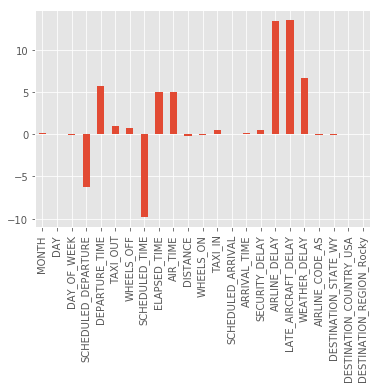

In [16]:
#Plot the coefficients
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(logreg.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

We see from our initial model that accuracy is already high. Let's take a closer look at some of the performance metrics of this model before we utilize grid search to improve the model, as well as our variables skewed heavily towards the delay indicators. We will proceed with evaluating model performance and then move towards improving results with GridSearch.

In [17]:
from sklearn import metrics as mt
conf = mt.confusion_matrix(y_test,yhat)
conf

array([[10395,    10],
       [  129,  1758]])

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test,yhat))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     10405
        1.0       0.99      0.93      0.96      1887

avg / total       0.99      0.99      0.99     12292



Both metrics, confusion matrix and classification report, show us that this is a high performing model. Recall is defined as
R = \frac{T_p}{T_p + F_n}.

We are interested in this metric in particular because we want to minimize our false negative rate because it is the most meaningful metric for this type of problem. A flight predicted as not arriving late when it actually is late, is considered "high cost" for this problem as we strive to make this a relevant operational metric because we aim to make this classification task actionable for the end user. 

We finally see the trade off curve plotted below. Our results allow us to achieve both high precision and recall, a rare finding in an imbalanced data set. 

Average precision-recall score: 0.97


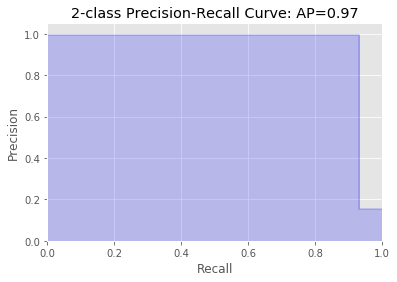

In [19]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, yhat)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test, yhat)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall Curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

#source: scikitlearn documentation. 

To recap, we performed variable selection and created a model based on the terms that were not penalized to 0 coefficients in L1 regularization. We saw that the model performed well based on an 80/20 train/test split. We will now investigate how to improve upon an already strong model using GridSearchCV. The variable we want to improve is C:"Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization" (scikit learn logistic regression documentation). 

In [20]:
#set up parameter grid search for C variable
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
logreg = LogisticRegression()
clf = GridSearchCV(logreg, param_grid)

#fit model
clf.fit(X_train_scaled,y_train)

In [21]:
#print the best paramter of C found and best score
print(clf.best_score_)
print(clf.best_params_)

0.993512040351
{'C': 1000}


We found the optimal parameter of C to be 1000. It is not computationally efficient to find the true optimum of C. However, give the score increase, we conclude this model is optimized. 

In [25]:
#print test accuracy using best estimator from gridsearch
grid_model = clf.best_estimator_
grid_model.fit(X_train_scaled, y_train)
grid_test = grid_model.predict(X_test_scaled)
print('Test accuracy: %.3f' % grid_model.score(X_test_scaled, y_test))

Test accuracy: 0.993


In [26]:
#evaluate performance via confusion matrix
conf = mt.confusion_matrix(y_test,grid_test)
conf

array([[10388,    17],
       [   74,  1813]])

In [27]:
#take a look at the classification report
print(classification_report(y_test,grid_test))

             precision    recall  f1-score   support

        0.0       0.99      1.00      1.00     10405
        1.0       0.99      0.96      0.98      1887

avg / total       0.99      0.99      0.99     12292



Additionally, we have imporved our the model performance, as both recall and F1-score have improved for our positive class of ARRIVAL DELAY = 1. 

In [28]:
# sort these attributes and print out model coefficients
zip_vars = zip(grid_model.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_DEPARTURE has weight of -38.4405351881
SCHEDULED_TIME has weight of -19.540826165
DESTINATION_STATE_WY has weight of -0.705158369657
WHEELS_ON has weight of -0.222777239942
DAY has weight of -0.0733102213927
DAY_OF_WEEK has weight of -0.0321799343521
DESTINATION_REGION_Rocky has weight of -0.0318213417967
AIRLINE_CODE_AS has weight of -0.00608340462361
DESTINATION_COUNTRY_USA has weight of 0.0
MONTH has weight of 0.0863524377239
SCHEDULED_ARRIVAL has weight of 0.121577209421
ARRIVAL_TIME has weight of 0.210826286345
DISTANCE has weight of 0.46221979865
TAXI_IN has weight of 0.756815971675
SECURITY_DELAY has weight of 0.879407215239
TAXI_OUT has weight of 1.26973306141
WHEELS_OFF has weight of 1.64561235624
ELAPSED_TIME has weight of 9.31646112104
AIR_TIME has weight of 9.38131629098
DEPARTURE_TIME has weight of 37.4677975689
WEATHER_DELAY has weight of 52.9589110783
AIRLINE_DELAY has weight of 87.0678793218
LATE_AIRCRAFT_DELAY has weight of 178.366834572


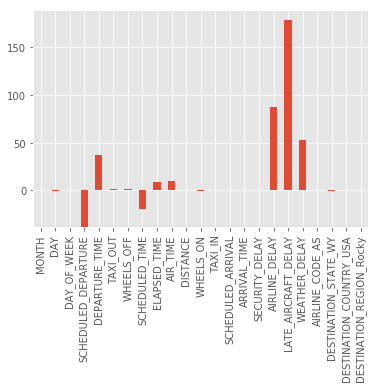

In [29]:
#Plot the coefficients
%matplotlib inline
plt.style.use('ggplot')


weights = pd.Series(grid_model.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

Interpret Feature Imortance
We see that our model assigns the highest importance to the delay variables. Late Aircraft delay, airline dleay, and weather delay are our top three predictors of a significant late arrival when the origin airport is Atlanta. These coefficients are positive, meaning as these delays increase, so does the probability of one arriving late to his/her destination. 

##Joe--need help her for interpretation. 

In regards to why the variables are so important: let's phrase this in the context of us trying to implement an operational metric with the goal of presenting to airport operations and developing metrics rather than delays at destination cause late arrivals. 

Create Models: Support Vector Machine

We will now transition to modeling our data using a support vector machine classifier. We have a high benchmark to hit in terms of accuracy. However, we are also interested in evaluating the other pros and cons of each model, discussed in model advantages. For example, if we can achieve a more sparse model with comparable accuracy utilizing SVM, we will likely tend to pick that method, as it is assumed our audience will prefer a simple solution. 

Just as with logistic regression, we begin with variable selection in order to reduce our massive data set to a more manageable size. 


In [70]:
# IMPORT ADDITIONAL MODULES FOR SVC AND GRAPHICS
from sklearn.feature_selection import SelectFromModel
import numpy as np
from matplotlib import style
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification

In [31]:
print("The Shape of the data frame after adding dummy variables is", ATL1.shape)
#create an object to scale data using standard scaler
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

#scale X to make zero mean and unit standard deviation
scl_obj.fit(X) 
X_scaled = scl_obj.transform(X)

The Shape of the data frame after adding dummy variables is (61460, 395)


In [73]:
#Begin variable selection
SVC_1 = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X,y)
Model_1 = SelectFromModel(SVC_1, prefit=True)
X_new_1 = Model_1.transform(X)
X_new_1.shape

(61460, 24)

We notice that SVC picked approximately the same attributes for modeling. We continue with building our initial model.

In [33]:
#print out the features that were not zeroed out from the L1 regularization.
#These will be the features to use in the sparse data set. 
Model_1.get_support(indices=True)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  22,  25, 287, 387, 391, 392], dtype=int64)

In [34]:
#make a new data frame of the selected 25 variables
ATL_trimmed = ATL1.ix[:,[0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  22,  25, 287, 387, 391, 392]]

In [35]:
ATL_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61460 entries, 38 to 931955
Data columns (total 25 columns):
MONTH                           61460 non-null int64
DAY                             61460 non-null int64
DAY_OF_WEEK                     61460 non-null int64
SCHEDULED_DEPARTURE             61460 non-null int64
DEPARTURE_TIME                  61460 non-null float64
TAXI_OUT                        61460 non-null float64
WHEELS_OFF                      61460 non-null float64
SCHEDULED_TIME                  61460 non-null float64
ELAPSED_TIME                    61460 non-null float64
AIR_TIME                        61460 non-null float64
DISTANCE                        61460 non-null int64
WHEELS_ON                       61460 non-null float64
TAXI_IN                         61460 non-null float64
SCHEDULED_ARRIVAL               61460 non-null int64
ARRIVAL_TIME                    61460 non-null float64
SECURITY_DELAY                  61460 non-null float64
AIRLINE_DELAY        

We noticed the differences between the variables selected for Logistic Regression compared to SVC. For example, Airline code, destination airport, destination state, and destination region are all different. 

What we see from the selected variables is not surprising: destination plays a large role and region is favored over the individual destination city variables. Also, we see that all of our delay variables are included, just as we saw in the logistic regression models. As we strive to translate this model to operational/business metrics, we want to pay close attention to the delay variable(s) with the largest coefficents, as they will help guide our final message. Time of departure is also a relevant feature. We will discuss more variable interpretation in the "Interpret Support Vectors" section.
Now that we have a smaller subset of features, we will begin the SVC development and improvement. We begin with a model that doesn't make use of Grid Search. We will address model performance and then proceed to improve the model by improving model parameters. 

In [36]:
#X values assigned
X_trimmed_svc = ATL_trimmed.values

In [49]:
#assign a train/test split of 80/20, 80% allocated for training, 20% allocated for test. 
X_train_svc,X_test_svc,y_train_svc,y_test_svc = train_test_split(X_trimmed_svc,y,test_size=0.2, random_state = 42)

#create instace of SVC
SVC = LinearSVC()

#scale our X values
#scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train_svc) 

# find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data
X_train_scaled_svc = scl_obj.transform(X_train_svc) # apply to training
X_test_scaled_svc = scl_obj.transform(X_test_svc)

#fit model
SVC.fit(X_train_scaled_svc,y_train_svc)

#Predict on test data set
y_hat_svc = SVC.predict(X_test_scaled_svc)

print ("Score:", SVC.score(X_test_scaled_svc, y_test_svc))

Score: 0.988285063456


In [50]:
# sort these attributes and print out model coefficients
zip_vars = zip(SVC.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_TIME has weight of -2.78324936025
SCHEDULED_DEPARTURE has weight of -2.33670234818
DESTINATION_REGION_Southeast has weight of -0.0791128105224
WHEELS_ON has weight of -0.0743568528498
DISTANCE has weight of -0.037976976206
WHEELS_OFF has weight of -0.0237326390252
DAY_OF_WEEK has weight of -0.0191223873245
DAY has weight of -0.00360671903696
DESTINATION_COUNTRY_USA has weight of 0.0
DESTINATION_REGION_Rocky has weight of 0.00223529769447
AIRLINE_CODE_MQ has weight of 0.00328185568146
MONTH has weight of 0.0237371103456
AIRLINE_CODE_DL has weight of 0.0297804171071
ARRIVAL_TIME has weight of 0.0375734403343
DESTINATION_CITY_New York has weight of 0.042140691087
SCHEDULED_ARRIVAL has weight of 0.0584208023567
TAXI_IN has weight of 0.119909274547
SECURITY_DELAY has weight of 0.142620588997
TAXI_OUT has weight of 0.212954719742
ELAPSED_TIME has weight of 1.3662770764
AIR_TIME has weight of 1.37210020832
DEPARTURE_TIME has weight of 2.40892763412
WEATHER_DELAY has weight of 3.0435

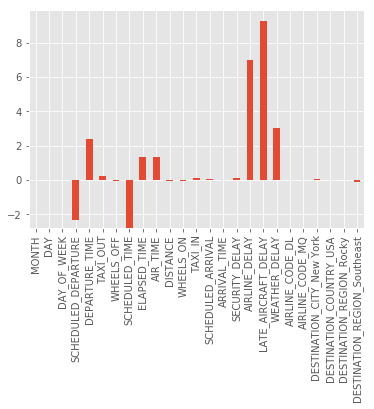

In [51]:
#Plot the coefficients
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(SVC.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

Our SVM modeling follows the same train/test split pattern as see in the logistic regression section. Because our features are on different scales, we also use the standard scaler function. The model is trained on 80% of the instances and tested on 20% of the instances. Our first indication of model performance is seen above using the SVC.score function. We see nearly equivalent performance as we saw on the first pass of logistic regression. 

Let's now take an even closer look at the various classification metrics. 

In [52]:
from sklearn import metrics as mt
conf_svc1 = mt.confusion_matrix(y_test_svc,y_hat_svc)
conf_svc1

array([[10401,     4],
       [  140,  1747]])

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test_svc,y_hat_svc))

             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99     10405
        1.0       1.00      0.93      0.96      1887

avg / total       0.99      0.99      0.99     12292



Average precision-recall score: 0.97


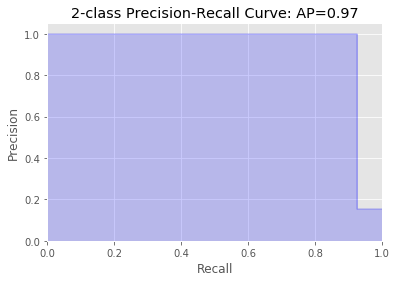

In [54]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_svc, y_hat_svc)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
precision, recall, _ = precision_recall_curve(y_test_svc, y_hat_svc)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall Curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

#source: scikitlearn documentation.

What we see above in the confusion matrix and classification report is exceptional performance. Our minority class, delays, are predicted well. To truly outperform logistic regression, we need to see better recall in the 1 class (arrival delays). Additionally, the precision-recall curve indicates strong precision/recall tradeoff without much of a sacrifice in the performance of either class. 

Before moving on to an optimized model, we will plot this model's coefficients. 

The SVM model's coefficients, much like the past models reinforce that the delays at the origin airport, ATL, have strong predictive power on the probability of a delayed arrival. 

To recap, we performed variable selection and created a SVC model based on the terms that were not penalized to 0 coefficients in L1 regularization. We saw that the model performed well based on an 80/20 train/test split. We will now investigate how to improve upon an already strong model using GridSearchCV. The variable we want to improve is C:"Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization" (scikit learn logistic regression documentation).

In [55]:
#set up parameter grid search for C variable
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
SVC = SVC = LinearSVC()
clf_svc = GridSearchCV(SVC, param_grid)

#fit model
clf_svc.fit(X_train_scaled_svc,y_train_svc)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [56]:
#print the best paramter of C found and best score
print(clf_svc.best_score_)
print(clf_svc.best_params_)

0.989952814839
{'C': 10}


In [58]:
#print test accuracy using best estimator from gridsearch
grid_model_svc = clf_svc.best_estimator_
grid_model_svc.fit(X_train_scaled_svc, y_train_svc)
gridpredict = grid_model_svc.predict(X_test_scaled_svc)
print('Test accuracy: %.3f' % grid_model_svc.score(X_test_scaled_svc, y_test_svc))

Test accuracy: 0.989


In [59]:
#evaluate performance via confusion matrix
conf_gridsvm = mt.confusion_matrix(y_test_svc,gridpredict)
conf_gridsvm

array([[10402,     3],
       [  136,  1751]])

In [60]:
#take a look at the classification report
print(classification_report(y_test_svc,yhatgridsvc))

             precision    recall  f1-score   support

        0.0       0.99      0.93      0.96     10405
        1.0       0.71      0.96      0.82      1887

avg / total       0.95      0.93      0.94     12292



In [61]:
# sort these attributes and print out model coefficients
zip_vars = zip(grid_model_svc.coef_.T, ATL_trimmed) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

SCHEDULED_DEPARTURE has weight of -2.95301770132
SCHEDULED_TIME has weight of -2.88300019425
WHEELS_ON has weight of -0.0882391782545
DESTINATION_REGION_Southeast has weight of -0.0663449630788
DISTANCE has weight of -0.0213999911817
DESTINATION_REGION_Rocky has weight of -0.020369786109
DAY_OF_WEEK has weight of -0.00962891210508
DESTINATION_COUNTRY_USA has weight of 0.0
DAY has weight of 0.000168282131627
AIRLINE_CODE_MQ has weight of 0.00645950557586
WHEELS_OFF has weight of 0.010470372617
MONTH has weight of 0.0196754589469
DESTINATION_CITY_New York has weight of 0.045822213709
SCHEDULED_ARRIVAL has weight of 0.0548770983376
AIRLINE_CODE_DL has weight of 0.0724126980934
ARRIVAL_TIME has weight of 0.0744352195236
TAXI_IN has weight of 0.124030022186
SECURITY_DELAY has weight of 0.1521665841
TAXI_OUT has weight of 0.200212815748
ELAPSED_TIME has weight of 1.40868493569
AIR_TIME has weight of 1.41688094237
DEPARTURE_TIME has weight of 2.98127038486
WEATHER_DELAY has weight of 3.980205

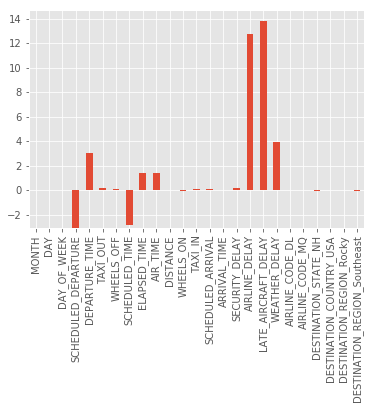

In [34]:
#Plot the coefficients
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(grid_model_svc.coef_[0],index=ATL_trimmed.columns)
weights.plot(kind='bar')
plt.show()

In [65]:
#support vectors
print(SVC.support_vectors_.shape)
#print(svm_clf.support_.shape)
#print(svm_clf.n_support_ )

AttributeError: 'LinearSVC' object has no attribute 'support_vectors_'